In [1]:
import torchvision as t
import torch
import numpy as np
import pandas as pd
#import gpytorch
import math
from matplotlib import pyplot as plt
import urllib.request
import os.path
from scipy.io import loadmat
from math import floor
import time
import gc
import FLOVE

In [22]:
from __future__ import print_function
import torch

## Check of Lanczos orthogonalization

In [23]:
def batch_symeig(mat):
    """
    """
    mat_orig = mat
    batch_shape = torch.Size(mat_orig.shape[:-2])
    matrix_shape = torch.Size(mat_orig.shape[-2:])

    # Smaller matrices are faster on the CPU than the GPU
    if mat.size(-1) <= 32:
        mat = mat.cpu()

    mat = mat.view(-1, *matrix_shape)
    eigenvectors = torch.empty(batch_shape.numel(), *matrix_shape, dtype=mat.dtype, device=mat.device)
    eigenvalues = torch.empty(batch_shape.numel(), matrix_shape[-1], dtype=mat.dtype, device=mat.device)

    for i in range(batch_shape.numel()):
        evals, evecs = mat[i].symeig(eigenvectors=True)
        mask = evals.ge(0)
        eigenvectors[i] = evecs * mask.type_as(evecs).unsqueeze(0)
        eigenvalues[i] = evals.masked_fill_(1 - mask, 1)

    return eigenvalues.type_as(mat_orig).view(*batch_shape, -1), eigenvectors.type_as(mat_orig).view_as(mat_orig)

In [24]:
def lanczos_tridiag(
    matmul_closure,
    max_iter,
    dtype,
    device,
    matrix_shape,
    batch_shape=torch.Size(),
    init_vecs=None,
    num_init_vecs=1,
    tol=1e-5,
):
    """
    """
    # Determine batch mode
    multiple_init_vecs = False

    if not callable(matmul_closure):
        raise RuntimeError(
            "matmul_closure should be a function callable object that multiples a (Lazy)Tensor "
            "by a vector. Got a {} instead.".format(matmul_closure.__class__.__name__)
        )

    # Get initial probe ectors - and define if not available
    if init_vecs is None:
        init_vecs = torch.randn(matrix_shape[-1], num_init_vecs, dtype=dtype, device=device)
        init_vecs = init_vecs.expand(*batch_shape, matrix_shape[-1], num_init_vecs)

    else:
        if settings.debug.on():
            if dtype != init_vecs.dtype:
                raise RuntimeError(
                    "Supplied dtype {} and init_vecs.dtype {} do not agree!".format(dtype, init_vecs.dtype)
                )
            if device != init_vecs.device:
                raise RuntimeError(
                    "Supplied device {} and init_vecs.device {} do not agree!".format(device, init_vecs.device)
                )
            if batch_shape != init_vecs.shape[:-2]:
                raise RuntimeError(
                    "batch_shape {} and init_vecs.shape {} do not agree!".format(batch_shape, init_vecs.shape)
                )
            if matrix_shape[-1] != init_vecs.size(-2):
                raise RuntimeError(
                    "matrix_shape {} and init_vecs.shape {} do not agree!".format(matrix_shape, init_vecs.shape)
                )

        num_init_vecs = init_vecs.size(-1)

    # Define some constants
    num_iter = min(max_iter, matrix_shape[-1])
    dim_dimension = -2

    # Create storage for q_mat, alpha,and beta
    # q_mat - batch version of Q - orthogonal matrix of decomp
    # alpha - batch version main diagonal of T
    # beta - batch version of off diagonal of T
    q_mat = torch.zeros(num_iter, *batch_shape, matrix_shape[-1], num_init_vecs, dtype=dtype, device=device)
    t_mat = torch.zeros(num_iter, num_iter, *batch_shape, num_init_vecs, dtype=dtype, device=device)

    # Begin algorithm
    # Initial Q vector: q_0_vec
    q_0_vec = init_vecs / torch.norm(init_vecs, 2, dim=dim_dimension).unsqueeze(dim_dimension)
    q_mat[0].copy_(q_0_vec)

    # Initial alpha value: alpha_0
    r_vec = matmul_closure(q_0_vec)
    alpha_0 = q_0_vec.mul(r_vec).sum(dim_dimension)

    # Initial beta value: beta_0
    r_vec.sub_(alpha_0.unsqueeze(dim_dimension).mul(q_0_vec))
    beta_0 = torch.norm(r_vec, 2, dim=dim_dimension)

    # Copy over alpha_0 and beta_0 to t_mat
    t_mat[0, 0].copy_(alpha_0)
    t_mat[0, 1].copy_(beta_0)
    t_mat[1, 0].copy_(beta_0)

    # Compute the first new vector
    q_mat[1].copy_(r_vec.div_(beta_0.unsqueeze(dim_dimension)))

    # Now we start the iteration
    for k in range(1, num_iter):
        # Get previous values
        q_prev_vec = q_mat[k - 1]
        q_curr_vec = q_mat[k]
        beta_prev = t_mat[k, k - 1].unsqueeze(dim_dimension)

        # Compute next alpha value
        r_vec = matmul_closure(q_curr_vec) - q_prev_vec.mul(beta_prev)
        alpha_curr = q_curr_vec.mul(r_vec).sum(dim_dimension, keepdim=True)
        # Copy over to t_mat
        t_mat[k, k].copy_(alpha_curr.squeeze(dim_dimension))

        # Copy over alpha_curr, beta_curr to t_mat
        if (k + 1) < num_iter:
            # Compute next residual value
            r_vec.sub_(alpha_curr.mul(q_curr_vec))
            # Full reorthogonalization: r <- r - Q (Q^T r)
            correction = r_vec.unsqueeze(0).mul(q_mat[: k + 1]).sum(dim_dimension, keepdim=True)
            correction = q_mat[: k + 1].mul(correction).sum(0)
            r_vec.sub_(correction)
            r_vec_norm = torch.norm(r_vec, 2, dim=dim_dimension, keepdim=True)
            r_vec.div_(r_vec_norm)

            # Get next beta value
            beta_curr = r_vec_norm.squeeze_(dim_dimension)
            # Update t_mat with new beta value
            t_mat[k, k + 1].copy_(beta_curr)
            t_mat[k + 1, k].copy_(beta_curr)

            # Run more reorthoganilzation if necessary
            inner_products = q_mat[: k + 1].mul(r_vec.unsqueeze(0)).sum(dim_dimension)
            could_reorthogonalize = False
            for _ in range(10):
                if not torch.sum(inner_products > tol):
                    could_reorthogonalize = True
                    break
                correction = r_vec.unsqueeze(0).mul(q_mat[: k + 1]).sum(dim_dimension, keepdim=True)
                correction = q_mat[: k + 1].mul(correction).sum(0)
                r_vec.sub_(correction)
                r_vec_norm = torch.norm(r_vec, 2, dim=dim_dimension, keepdim=True)
                r_vec.div_(r_vec_norm)
                inner_products = q_mat[: k + 1].mul(r_vec.unsqueeze(0)).sum(dim_dimension)

            # Update q_mat with new q value
            q_mat[k + 1].copy_(r_vec)

            if torch.sum(beta_curr.abs() > 1e-6) == 0 or not could_reorthogonalize:
                break

    # Now let's transpose q_mat, t_mat intot the correct shape
    num_iter = k + 1

    # num_init_vecs x batch_shape x matrix_shape[-1] x num_iter
    q_mat = q_mat[: num_iter + 1].permute(-1, *range(1, 1 + len(batch_shape)), -2, 0).contiguous()
    # num_init_vecs x batch_shape x num_iter x num_iter
    t_mat = t_mat[: num_iter + 1, : num_iter + 1].permute(-1, *range(2, 2 + len(batch_shape)), 0, 1).contiguous()

    # If we weren't in batch mode, remove batch dimension
    if not multiple_init_vecs:
        q_mat.squeeze_(0)
        t_mat.squeeze_(0)

    # We're done!
    return q_mat, t_mat


def lanczos_tridiag_to_diag(t_mat):
    """
    Given a num_init_vecs x num_batch x k x k tridiagonal matrix t_mat,
    returns a num_init_vecs x num_batch x k set of eigenvalues
    and a num_init_vecs x num_batch x k x k set of eigenvectors.
    TODO: make the eigenvalue computations done in batch mode.
    """
    return batch_symeig(t_mat)

In [25]:
import numpy as np
import pandas as pd
n=100
Matrix=np.random.rand(n,n)
Matrix=torch.Tensor(Matrix)
#print(Matrix)

In [26]:
def matmul(vec):
    return torch.matmul(Matrix,vec)
t=100
dd=[]
tt=[]
while t<=1000:
    Q,T=lanczos_tridiag(matmul,t,torch.float32,'cpu',(n,n))
    Z=(Q.numpy()).transpose().conjugate()
    dd.append(np.linalg.norm(np.dot(Q.numpy(),Z)-np.identity(n)))
    tt.append(t)
    t=t+10
#print(np.linalg.norm(np.dot(Q.numpy(),Z)-np.identity(n)))

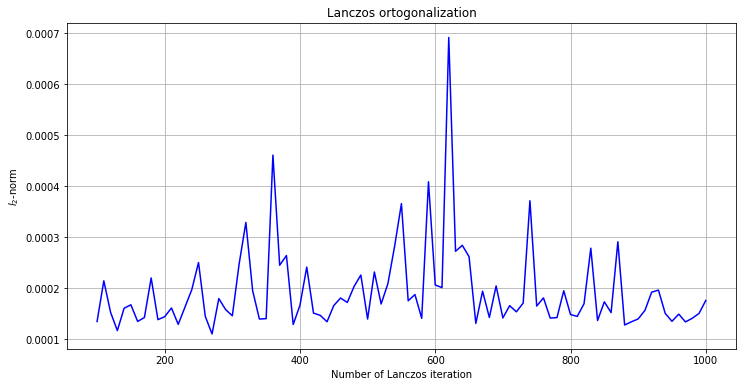

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.set_title('Lanczos ortogonalization')
ax.plot(tt,dd,'blue')
ax.set_xlabel('Number of Lanczos iteration')
ax.set_ylabel('$l_2$-norm')
ax.grid(True)
plt.savefig('lanczos_orthog.png', dpi=600, quality=95)
plt.show()

## Here we used Bayessian GP model in order to use it as a baseline and compare with our implementation.

In [35]:
class ExactGPModel(FLOVE.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = FLOVE.means.ConstantMean()
        self.covar_module = FLOVE.kernels.ScaleKernel(FLOVE.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return FLOVE.distributions.MultivariateNormal(mean_x, covar_x)
if not os.path.isfile('skillcraft.mat'):
    #print('Downloading \'skillcraft\' UCI dataset...')
    urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1xQ1vgx_bOsLDQ3RLbJwPxMyJHW7U9Eqd', 'skillcraft.mat')
    
    
data = torch.Tensor(loadmat('skillcraft.mat')['data'])
X = data[:, :-1]
X = X - X.min(0)[0]
X = 2 * (X / X.max(0)[0]) - 1
y = data[:, -1]

In [36]:
temp=100
matrix_data=np.zeros((33,5))
i=0
while temp<=3300:
    
    
    Xt=X.numpy()
    yt=y.numpy()
    Xt=X[:temp]
    yt=y[:temp]
    #print(y)
    Xt=torch.Tensor(Xt)
    yt=torch.Tensor(yt)
    # Use the first 80% of the data for training, and the last 20% for testing.
    train_n = int(floor(0.4*len(Xt)))

    train_x = Xt[:train_n,:].contiguous()
    train_y = yt[:train_n].contiguous()

    test_x = Xt[train_n:,:].contiguous()
    test_y = yt[train_n:].contiguous()

    

    # initialize likelihood and model
    likelihood = FLOVE.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)

    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = FLOVE.mlls.ExactMarginalLogLikelihood(likelihood, model)

    training_iterations = 50
    def train():
        for i in range(training_iterations):
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y)
            loss.backward()
            #print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
            
            optimizer.step()
            temp=loss.item()
            return temp     
    err=train()


    # Set into eval mode
    model.eval()
    likelihood.eval()

    with torch.no_grad():
        start_time = time.time()
        preds = model(test_x)
        exact_covar = preds.covariance_matrix
        exact_covar_time = time.time() - start_time
    # Clear as much 'stuff' as possible
    gc.collect()
    torch.cuda.empty_cache()
    model.train()
    likelihood.train()

    # Set into eval mode
    model.eval()
    likelihood.eval()

    # The 
    with torch.no_grad(), FLOVE.settings.fast_pred_var(1), FLOVE.settings.max_root_decomposition_size(25):
        start_time = time.time()
        preds = model(test_x)
        fast_covar = preds.covariance_matrix
        fast_time_no_cache = time.time() - start_time
    '''
    with torch.no_grad(), FLOVE.settings.fast_pred_var(), FLOVE.settings.max_root_decomposition_size(25):
        start_time = time.time()
        preds = model(test_x)
        fast_covar = preds.covariance_matrix
        fast_time_with_cache = time.time() - start_time
    '''
    print(temp)
    print('Time to compute exact mean + covariances: {:.2f}s'.format(exact_covar_time))
    print('Time to compute mean + covariances (no cache) {:.2f}s'.format(fast_time_no_cache))
    #print('Time to compute mean + variances (cache): {:.2f}s'.format(fast_time_with_cache))
    #print('MAE between exact covar matrix and fast covar matrix: {}'.format((exact_covar - fast_covar).abs().mean()))
    #print(np.array(preds.loc))
    #print(test_y.numpy()) 
    print('accur: {}'.format(np.linalg.norm(np.array(preds.loc)-test_y.numpy())))
    #np.linalg.norm(np.array(preds.loc)-test_y.numpy())
    matrix_difference = (exact_covar - fast_covar).data.numpy()
    matrix_data[i]=[temp,exact_covar_time,fast_time_no_cache,np.linalg.norm(matrix_difference, 2),(training_iterations+temp*math.log(temp))*0.01]
    i=i+1
    temp=temp+100
    '''(exact_covar - fast_covar).abs().mean(),'''
    '''accuracy_cov':matrix_data[:,3],'''
dd=pd.DataFrame({'N':matrix_data[:,0],'exact_covar_time':matrix_data[:,1],'fast':matrix_data[:,2],'accur':matrix_data[:,3],'nlogn':matrix_data[:,4]})
dd.to_excel('data.xlsx')
#print(matrix_data)

100
Time to compute exact mean + covariances: 0.10s
Time to compute mean + covariances (no cache) 0.06s
accur: 2.7487595081329346
200
Time to compute exact mean + covariances: 0.02s
Time to compute mean + covariances (no cache) 0.02s
accur: 3.2642571926116943
300
Time to compute exact mean + covariances: 0.03s
Time to compute mean + covariances (no cache) 0.03s
accur: 3.5419797897338867
400
Time to compute exact mean + covariances: 0.05s
Time to compute mean + covariances (no cache) 0.03s
accur: 4.159011363983154
500
Time to compute exact mean + covariances: 0.08s
Time to compute mean + covariances (no cache) 0.04s
accur: 4.725273132324219
600
Time to compute exact mean + covariances: 0.07s
Time to compute mean + covariances (no cache) 0.04s
accur: 5.3903422355651855
700
Time to compute exact mean + covariances: 0.10s
Time to compute mean + covariances (no cache) 0.04s
accur: 6.115330219268799
800
Time to compute exact mean + covariances: 0.12s
Time to compute mean + covariances (no ca

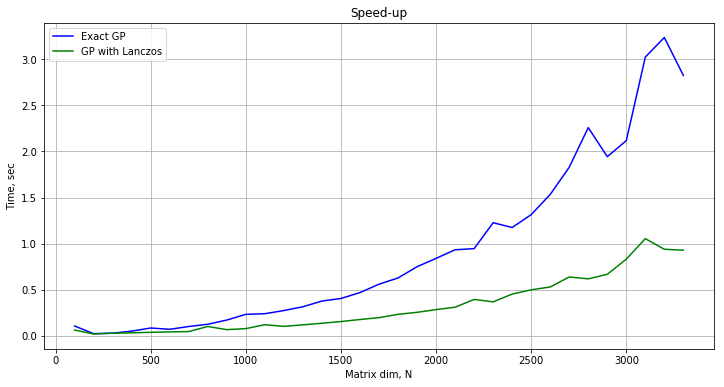

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.set_title('Speed-up')
ax.plot(dd['N'].tolist(),dd['exact_covar_time'].tolist(),'blue',label='Exact GP')
ax.plot(dd['N'].tolist(),dd['fast'].tolist(),'green', label='GP with Lanczos')
#plt.plot(dd['N'].tolist(),(dd['nlogn']*0.01).tolist())
ax.legend()
ax.set_xlabel('Matrix dim, N')
ax.set_ylabel('Time, sec')
ax.grid(True)
plt.savefig('speed_up.png', dpi=600, quality=95)
plt.show()

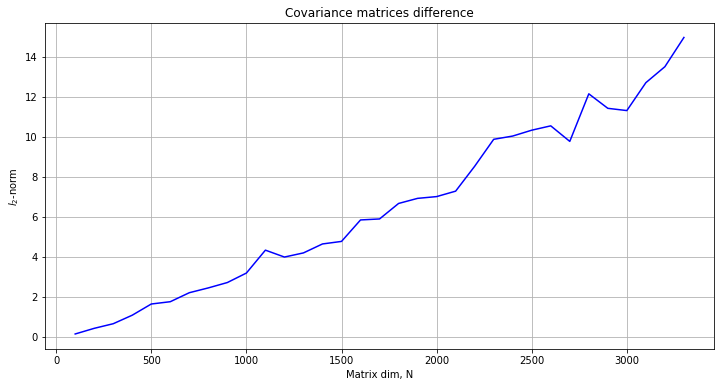

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.set_title('Covariance matrices difference')
ax.plot(dd['N'].tolist(),dd['accur'].tolist(), 'blue')
ax.set_xlabel('Matrix dim, N')
ax.set_ylabel('$l_2$-norm')
#plt.plot(dd['N'].tolist(),(dd['nlogn']*0.01).tolist())
ax.grid(True)
plt.savefig('solution_acc.png', dpi=600, quality=95)
plt.show()

## Same PSD matrix K for Chebyshev and Lanchoz

In [85]:
A = torch.rand(100,100) #generating random matrix and multiplication it by transposed to make it positive define
K = torch.matmul(A,A.t())
K_nump = K.numpy()
n = K_nump.shape[0]

## Chebyshev

In [86]:

eigs, vect=np.linalg.eig(K_nump)
lambda_max=max(eigs)
lambda_min=min(eigs)
if (np.abs(lambda_min)<=1)and(np.abs(lambda_max)<=1): #attachment eginvalues to interval (-1, 1)
    B=K_nump
    alpha=1
else:
    shift=0.1
    alpha=(lambda_max-lambda_min)/(lambda_max+lambda_min)+shift #add shift in order to eigenvalues be inside the interval (-1, 1)
    beta=(lambda_max+lambda_min)/2
    B=K_nump/(beta*alpha)-np.eye(n)/alpha
def roots(m):#comfortable calculating of Chebyshev polynomial roots
    if m==0:
        return 1
    else:
        c = np.zeros(m+1)
        c[m] = 1
        roots = np.polynomial.chebyshev.chebroots(c)
        return roots
m = 100
root_cheb = roots(m+1)
x=root_cheb #grid for log decomposition using Chebyshev polynomials
y=np.log(1+(alpha-shift)*x)
coef=np.polynomial.chebyshev.chebfit(x, y, m) #calculation of coefficients for log decomposition using Chebyshev polynomials
#mean value calculating
prob_vec_num = 200
log_det_out = np.zeros(prob_vec_num)
var_log_det = np.zeros(prob_vec_num)

for num_of_prob_vec in range(1, prob_vec_num+1):
    log_det = np.zeros(num_of_prob_vec)
    for i in range(num_of_prob_vec):
        z=np.random.uniform(-1,1,(B.shape[0],1))
        z=z/np.linalg.norm(z)
        w=np.zeros((z.shape[0],m+1))
        w[:,0]=z.reshape(z.shape[0])
        w[:,1]=B.dot(z).reshape(z.shape[0])
        for j in range(2,m+1):
            w[:,j]=2*B.dot(w[:,j-1])-w[:,j-2]
        log_det[i]=z.T.dot(w).dot(coef)
       
    log_det_out[num_of_prob_vec-1] = np.mean(log_det)
    var_log_det[num_of_prob_vec-1] = np.var(log_det)

s, log_det_embed=np.linalg.slogdet(np.eye(n)+(alpha-shift)*B)



##  Here we calculated
$$ \operatorname{tr}(\log{(I+\alpha B)})$$

In [87]:
print('Approximation of log(det(A)) by Chebyshev for 100 probe vectors:', n*log_det_out[-1])
print('Embedded log(det(A)):', log_det_embed)
print('Variance of log(det(A)) by Chebyshev for 100 probe vectors:', n*var_log_det[-1])


Approximation of log(det(A)) by Chebyshev for 100 probe vectors: -230.6423632591434
Embedded log(det(A)): -230.64386809131952
Variance of log(det(A)) by Chebyshev for 100 probe vectors: 0.19336379334391363


## For Lanczos iteration

In [32]:
 
if not os.path.isfile('skillcraft.mat'):
    #print('Downloading \'skillcraft\' UCI dataset...')
    urllib.request.urlretrieve('https://drive.google.com/uc?export=download&id=1xQ1vgx_bOsLDQ3RLbJwPxMyJHW7U9Eqd', 'skillcraft.mat')


data = torch.Tensor(loadmat('skillcraft.mat')['data'])

#print(y)
#print(X)
#print(data.shape)
X = data[:, :-1]
X = X - X.min(0)[0]
X = 2 * (X / X.max(0)[0]) - 1
y = data[:, -1]
# Use the first 80% of the data for training, and the last 20% for testing.
train_n = int(floor(0.4*len(X)))

train_x = X[:train_n,:].contiguous()
train_y = y[:train_n].contiguous()

test_x = X[train_n:,:].contiguous()
test_y = y[train_n:].contiguous()

class ExactGPModel(FLOVE.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = FLOVE.means.ConstantMean()
        self.covar_module = FLOVE.kernels.ScaleKernel(FLOVE.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return FLOVE.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = FLOVE.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = FLOVE.mlls.ExactMarginalLogLikelihood(likelihood, model)

temp=10
matrix_data=np.zeros((100,2))
i=0 
while temp<=1000:
    def train():
        for i in range(training_iterations):
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y)
            loss.backward()
            #print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))

            optimizer.step()
            return loss.item()  
    err=train()
    matrix_data[i]=[temp,err]
    i=i+1
    temp=temp+10

# Set into eval mode
model.eval()
likelihood.eval()

with torch.no_grad():
    start_time = time.time()
    preds = model(test_x)
    exact_covar = preds.covariance_matrix
    exact_covar_time = time.time() - start_time
#print('Time to compute exact mean + covariances: {:.2f}s'.format(exact_covar_time))
# Clear as much 'stuff' as possible
gc.collect()
torch.cuda.empty_cache()
model.train()
likelihood.train()

# Set into eval mode
model.eval()
likelihood.eval()

# The 
#temp=10
#matrix_data=np.zeros((100,2))
#i=0 
#while temp<=1000:
with torch.no_grad(), FLOVE.settings.fast_pred_var(), FLOVE.settings.max_root_decomposition_size(25):#, FLOVE.settings.max_lanczos_quadrature_iterations(temp):
    #print(FLOVE.settings.max_lanczos_quadrature_iterations(temp))
    start_time = time.time()
    preds = model(test_x)
    fast_time_no_cache = time.time() - start_time
        #err=np.linalg.norm(np.array(preds.loc)-test_y.numpy())
        #print(err)
        #matrix_data[i]=[temp,err]
        #i=i+1
        #temp=temp+10

    
dd=pd.DataFrame({'iter':matrix_data[:,0],'err':matrix_data[:,1]})
dd.to_excel('data_ert.xlsx')

with torch.no_grad(), FLOVE.settings.fast_pred_var(), FLOVE.settings.max_root_decomposition_size(25):
    start_time = time.time()
    preds = model(test_x)
    fast_covar = preds.covariance_matrix
    fast_time_with_cache = time.time() - start_time

print(temp)
print('Time to compute exact mean + covariances: {:.2f}s'.format(exact_covar_time))
#print('Time to compute without uskorenie {:.2f}s'.format(time_train_without_smth))
print('Time to compute mean + covariances (no cache) {:.2f}s'.format(fast_time_no_cache))
#print('Time to compute mean + variances (cache): {:.2f}s'.format(fast_time_with_cache))
print('MAE between exact covar matrix and fast covar matrix: {}'.format((exact_covar - fast_covar).abs().mean()))
#print(np.array(preds.loc))
#print(test_y.numpy()) 
print('accur: {}'.format(np.linalg.norm(np.array(preds.loc)-test_y.numpy())))
#np.linalg.norm(np.array(preds.loc)-test_y.numpy())

#print(matrix_data)

1010
Time to compute exact mean + covariances: 3.07s
Time to compute mean + covariances (no cache) 0.43s
MAE between exact covar matrix and fast covar matrix: 0.0004884358495473862
accur: 11.350859642028809


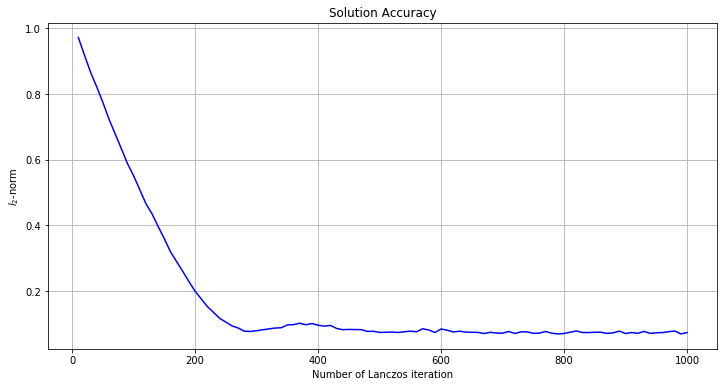

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.set_title('Solution Accuracy')
ax.plot(dd['iter'].tolist(),dd['err'].tolist(),'blue')
ax.set_xlabel('Number of Lanczos iteration')
ax.set_ylabel('$l_2$-norm')
#plt.plot(dd['N'].tolist(),(dd['nlogn']*0.01).tolist())
ax.grid(True)
plt.savefig('num_of_lanczos_iter.png', dpi=600, quality=95)
plt.show()

## Here we check Lanchoz Tridiagonalization method for estimation log_det of PSD matrix R 

In [103]:
from FLOVE.functions import _inv_quad_log_det
from FLOVE.utils import lanczos
from FLOVE.utils.lanczos import lanczos_tridiag,lanczos_tridiag_to_diag
from FLOVE.utils.eig import batch_symeig
import torch
from torch.autograd import Function
from FLOVE.utils.stochastic_lq import StochasticLQ
from FLOVE.utils import linear_cg
from FLOVE import settings

import numpy as np
import scipy as sp
#n=100
#max_iter=2*n
#R=np.random.rand(n,n)
R=K_nump
def matmul(b):
    Temp=torch.Tensor(R)
    return torch.matmul(Temp,b)

#Q=stochastic_lq.StochasticLQ(max_iter=it,num_random_probes=num_rand_v)
#eigenvalues,eigenvectors=lanczos_tridiag_to_diag(tridiag)
#A=InvQuadLogDet()
#Q.evaluate(tridiag.shape,diag,eige,[lambda x: x.log()])
#print(Q.evaluate(R.shape,))

q_mat,t_mat=lanczos_tridiag(matmul,max_iter=max_iter,dtype=torch.float32,device='cpu',matrix_shape=R.shape)
#eigenvalues, eigenvectors = lanczos_tridiag_to_diag(t_mat)
q_mat=q_mat.numpy()
t_mat=t_mat.numpy()
eigenvalues, eigenvectors=np.linalg.eig(t_mat)
#print(eigenvalues)
eigenvalues=torch.Tensor(eigenvalues)
eigenvectors=torch.Tensor(eigenvectors)
'''
it=500
num_rand_v=10
max_iter=it,num_random_probes=num_rand_v
'''
#print(t_mat.numpy().shape)
#print(eigenvalues.shape)
#print(eigenvectors.shape)
slq = StochasticLQ()


def slq(num_random_probes,eigenvalues,eigenvectors,matrix_shape):
    eigenvalues=eigenvalues.numpy()
    eigenvectors=eigenvectors.numpy()
    batch_shape = eigenvalues.shape[1:-1]
    log_det=0
    values=[]
    #print(eigenvalues)
    for j in range(num_random_probes):
        
        temp=np.random.normal(loc=0.0, scale=2.0, size=matrix_shape)
        #temp=eigenvectors[j]
        eigenvectors_for_probe = temp/np.linalg.norm(temp)
        eigenvecs_first_component = np.dot(eigenvectors.T,eigenvectors_for_probe)
        for_var=0
        for i in range(eigenvalues.shape[0]):
            # num_random_probes<=N - shape of matrix
            eigenvalues_for_probe = eigenvalues[i]
            func_eigenvalues = np.log(eigenvalues_for_probe)
            mu_i=eigenvecs_first_component[i]
            dot_products = (mu_i**2)* func_eigenvalues
            #dot_products2=(mu_i**2)* func2_eigenvalues
            log_det = log_det +  matrix_shape*1.0 / num_random_probes* dot_products
            for_var=dot_products+for_var
        values.append(for_var)
    return n*np.mean(values),np.var(values)

variance=[]
rel_difference=[]
s,log=np.linalg.slogdet(R)
for i in range(3,200):
    log_det_term,var=slq(i,eigenvalues,eigenvectors,eigenvectors.numpy().shape[0])
    variance.append(var)
    rel_difference.append(np.abs(log_det_term-log)/log)
#print(log_det_term)
s,log=np.linalg.slogdet(R)
print(log)
x=list(range(3,200))
y=rel_difference
#Log_det=_inv_quad_log_det.InvQuadLogDet().forward(R,dtype=torch.float32,device='cpu',matrix.shape=R.shape,log_det=True, inv_quad=False)

120.17574


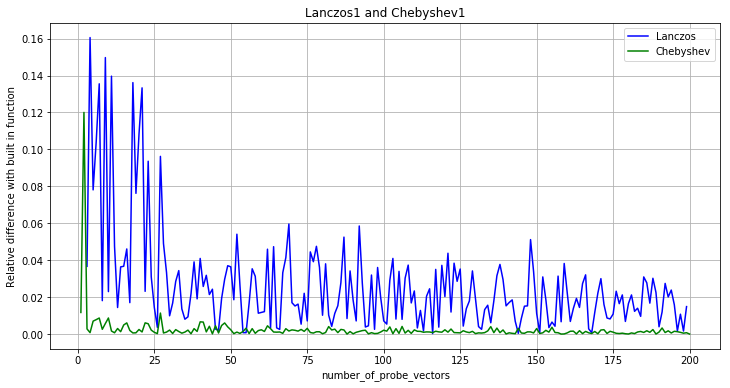

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.set_title('Lanczos1 and Chebyshev1')
plt.plot(x,y,color='b',label='Lanczos')
plt.plot(range(1, prob_vec_num+1), np.abs((n*log_det_out-log_det_embed)/log_det_embed), color = 'g',label='Chebyshev')
ax.set_xlabel('number_of_probe_vectors')
ax.set_ylabel('Relative difference with built in function')
#plt.plot(dd['N'].tolist(),(dd['nlogn']*0.01).tolist())
ax.grid(True)
plt.savefig('relative_Lanchoz_acc.png', dpi=600, quality=95)
plt.legend()
plt.show()

In [105]:
x=list(range(3,200))
y=variance

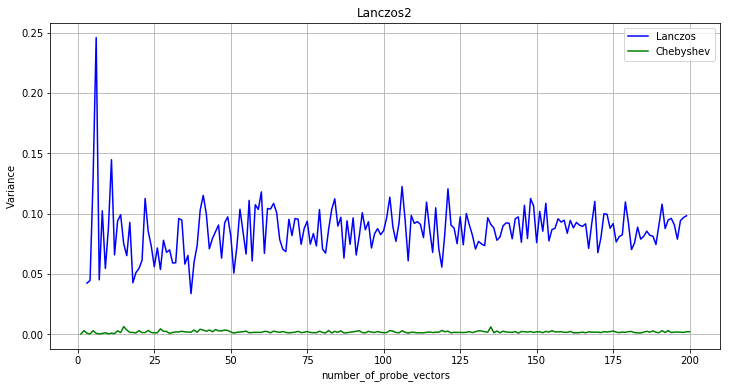

In [106]:
fig1, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.set_title('Lanczos2')
plt.plot(x,y,color='b',label='Lanczos')
ax.set_xlabel('number_of_probe_vectors')
ax.set_ylabel('Variance')
plt.plot(range(1, prob_vec_num+1), var_log_det, color = 'g',label='Chebyshev')
#plt.plot(dd['N'].tolist(),(dd['nlogn']*0.01).tolist())
ax.grid(True)
plt.savefig('Variance_Lanchoz_acc.png', dpi=600, quality=95)
plt.legend()
plt.show()